# Testing FOOOF with Synthetic Data

This notebook synthesizes synthetic power spectra, and tests FOOOF's performance on them.

In [1]:
%matplotlib inline

from collections import Counter

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from fooof import FOOOF, FOOOFGroup, fit_fooof_group_3d
from fooof.synth import gen_power_spectrum, gen_group_power_spectra

In [2]:
# Import project specific (local) custom code
from syn_utils import *
from syn_plts import *

In [3]:
# Set random seed
import random
random.seed(999)

In [4]:
sns.set_style('white')

In [5]:
%load_ext autoreload

In [6]:
%autoreload 2
from syn_plts import *

## Check Generation

In [7]:
# Test generate a power spectrum
f_range = [2, 40]
bg = [0, 1]
osc = [10, 0.5, 2]
nlv = 0.
freq_res = 0.25

fs, ps = gen_power_spectrum(f_range, bg, osc, nlv, freq_res)

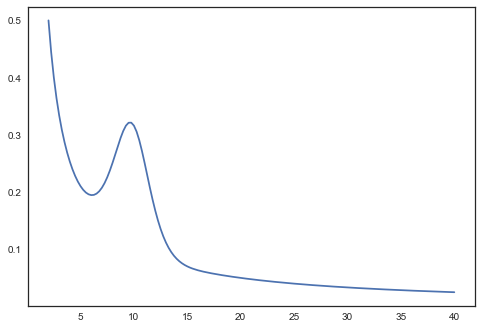

In [8]:
# Plot example synthesized power spectrum
plt.plot(fs, ps)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                          0.0151, 1.0095                                          
                                                                                                  
                                       1 peaks were found:                                        
          

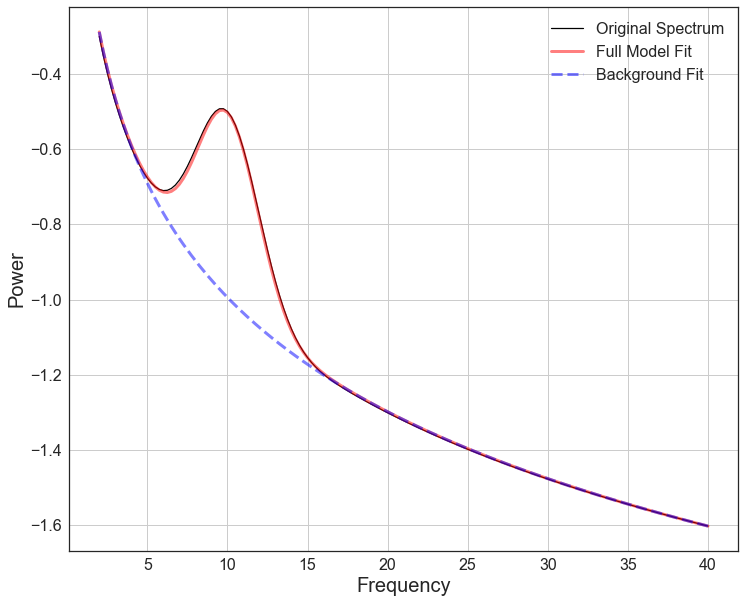

In [9]:
fm = FOOOF()
fm.report(fs, ps, plt_log=False)

In [10]:
# Compare actual parameters to FOOOF fit
print(bg, '\t', fm.background_params_)
print(osc, '\t', fm._gaussian_params)

[0, 1] 	 [ 0.01505844  1.00946517]
[10, 0.5, 2] 	 [[ 10.02088734   0.49164941   1.92918988]]


## Synthetic Generation Settings

Settings defined in syn_utils - check them. 

In [11]:
print_settings(N_OSCS_OPTS, N_OSCS_PROBS, '# of oscs')

Parameter definition for # of oscs 

	Value 	 Probability
	0 	 33.3%
	1 	 33.3%
	2 	 33.3%


In [12]:
print_settings(CF_OPTS, CF_PROBS, 'CFs')

Parameter definition for CFs 

	Value 	 Probability
	3 	 0.9%
	4 	 1.1%
	5 	 3.0%
	6 	 5.2%
	7 	 4.1%
	8 	 4.7%
	9 	 6.9%
	10 	 9.1%
	11 	 6.0%
	12 	 3.6%
	13 	 3.0%
	14 	 2.8%
	15 	 3.1%
	16 	 3.1%
	17 	 3.4%
	18 	 4.2%
	19 	 4.7%
	20 	 3.9%
	21 	 5.0%
	22 	 5.0%
	23 	 2.9%
	24 	 2.8%
	25 	 2.7%
	26 	 2.2%
	27 	 2.0%
	28 	 1.5%
	29 	 1.0%
	30 	 0.7%
	31 	 0.4%
	32 	 0.3%
	33 	 0.3%
	34 	 0.2%


In [13]:
print_settings(AMP_OPTS, AMP_PROBS, 'AMPs')

Parameter definition for AMPs 

	Value 	 Probability
	0.15 	 25.0%
	0.2 	 25.0%
	0.25 	 25.0%
	0.4 	 25.0%


In [14]:
print_settings(BW_OPTS, BW_PROBS, 'BWs')

Parameter definition for BWs 

	Value 	 Probability
	1.0 	 33.3%
	2.0 	 33.3%
	3.0 	 33.3%


In [15]:
print_settings(OFF_OPTS, OFF_PROBS, 'background offset')

Parameter definition for background offset 

	Value 	 Probability
	0 	 100.0%


In [16]:
print_settings(SL_OPTS, SL_PROBS, 'background slope')

Parameter definition for background slope 

	Value 	 Probability
	0.5 	 25.0%
	1 	 25.0%
	1.5 	 25.0%
	2 	 25.0%


In [17]:
# Sanity check probabilities are set correctly
for probs in [CF_PROBS, AMP_PROBS, BW_PROBS, OFF_PROBS, SL_PROBS]:
    assert np.isclose(sum(probs), 1, 1e-10)
print('All probabilities check out.')

All probabilities check out.


## Synthetic Fitting: One Peak Across Noise Levels

In [18]:
# Settings for PSD generation
f_range = [2, 40]
f_res = 0.25

# Set the number of PSDs - this is per noise condition
n_psds = 1000

# Set the noise levels to use
nlvs = [0.0, 0.025, 0.050, 0.10, 0.15]

# Use generators to sample peak & background parameters
peaks = gen_osc_def(1)
bgs = gen_bg_def()

In [19]:
# Get data sizes
n_nlvs = len(nlvs)
n_freqs = int((f_range[1] - f_range[0]) / f_res + 1)

In [20]:
# Generate power spectra
freqs = np.empty(shape=n_freqs)
psds = np.empty(shape=[n_nlvs, n_psds, n_freqs])
op_syn_params = [None] * n_nlvs

for n_ind, nlv in enumerate(nlvs):
    freqs, psds[n_ind, :, :], op_syn_params[n_ind] = gen_group_power_spectra(n_psds, f_range, bgs, peaks, nlv, f_res)
    
# Check shape
print('n_nlvs, n_spectra, n_freqs : ', psds.shape)

n_nlvs, n_spectra, n_freqs :  (5, 1000, 153)


In [21]:
# Extract ground truth values
osc_truths, bg_truths = get_ground_truth(op_syn_params)

In [22]:
# Initialize FOOOFGroup to test with
op_fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6)

# Fit power spectra - same FOOOF settings across each group of synthetic power spectra
op_fgs = fit_fooof_group_3d(op_fg, freqs, psds)

In [23]:
# # Alternatively:
# # Fit power spectra - adapting FOOOF settings for each group of synthetic power spectra
# fgs = []
# for nlv, nlv_psds in zip(nlvs, psds):
#     fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6, min_peak_amplitude=5*nlv)
#     fg.fit(freqs, nlv_psds)
#     fgs.append(fg.copy())

In [24]:
# Extract data of interest from FOOOF fits
osc_fits, bg_fits, err_fits, r2_fits, n_oscs = get_fit_data(op_fgs)

In [25]:
# Calculate error
osc_errors = np.abs(osc_truths - osc_fits) # absolute deviation
bg_errors = np.abs(bg_truths - bg_fits)

#osc_errors = (osc_truths - osc_fits)**2   # squared error
#bg_errors = (bg_truths - bg_fits)**2

In [26]:
# Pull out error per oscillations parameter
cf_errors = osc_errors[:, :, 0]
amp_errors = osc_errors[:, :, 1]
bw_errors = osc_errors[:, :, 2]

# Pull out error per background parameter
off_errors = bg_errors[:, :, 0]
sl_errors = bg_errors[:, :, 1]

In [27]:
# Plot Settings
#avg = 'mean'
#avg = 'median'
#err = 'sem'

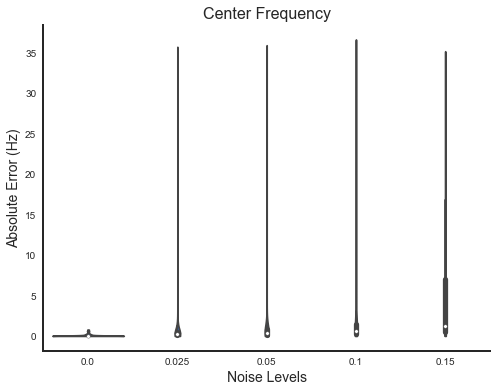

In [28]:
#plot_errors(cf_errors, 'CF', avg, err)
plot_errors_violin(cf_errors, 'Center Frequency', y_label='Absolute Error (Hz)', save_fig=True, save_name='1Peak-CF')
#plt.ylim([-0.5, 5])

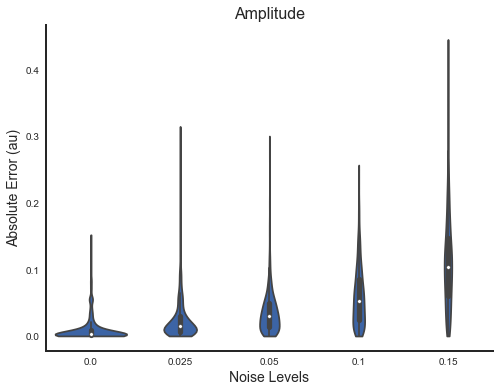

In [29]:
#plot_errors(amp_errors, 'Amp', avg, err)
plot_errors_violin(amp_errors, 'Amplitude', y_label='Absolute Error (au)', save_fig=True, save_name='1Peak-Amp')

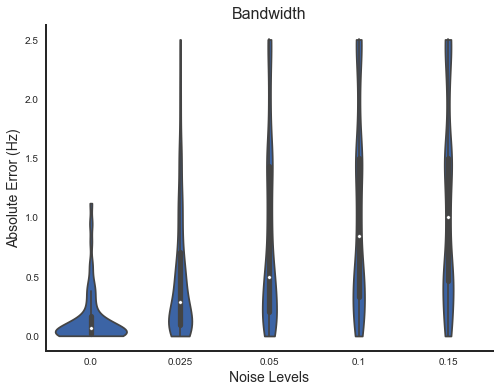

In [30]:
#plot_errors(bw_errors, 'BW', avg, err)
plot_errors_violin(bw_errors, 'Bandwidth', y_label='Absolute Error (Hz)', save_fig=True, save_name='1Peak-BW')

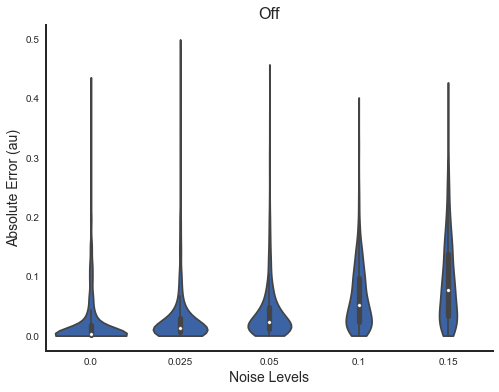

In [31]:
#plot_errors(off_errors, 'Off', avg, err)
plot_errors_violin(off_errors, 'Off', y_label='Absolute Error (au)')

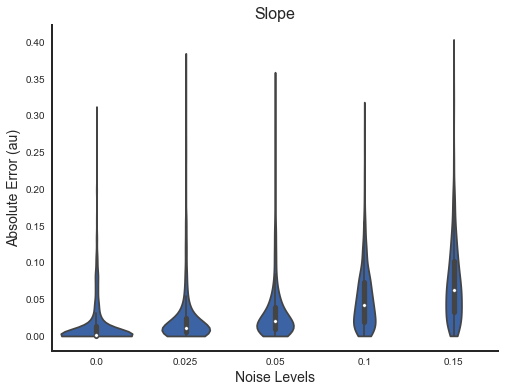

In [32]:
#plot_errors(sl_errors, 'Sl', avg, err)
plot_errors_violin(sl_errors, 'Slope', y_label='Absolute Error (au)', save_fig=True, save_name='1Peak-Sl')

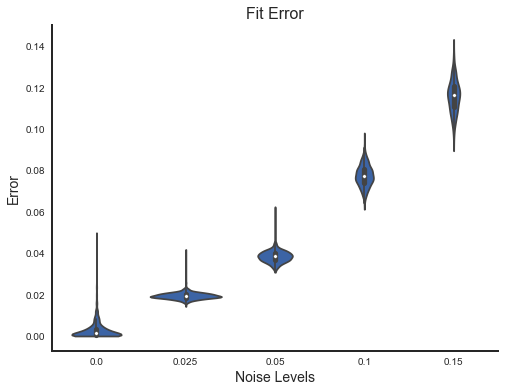

In [33]:
#plot_errors(err_fits, 'Error', avg, err)
plot_errors_violin(err_fits, 'Fit Error', y_label='Error', save_fig=True, save_name='1Peak-Err')

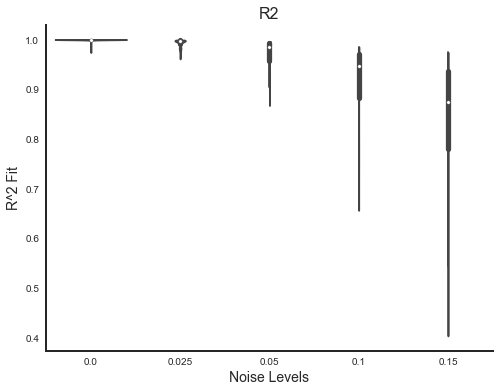

In [34]:
#plot_errors(r2_fits, 'R2', avg, err)
plot_errors_violin(r2_fits, 'R2', y_label='R^2 Fit')

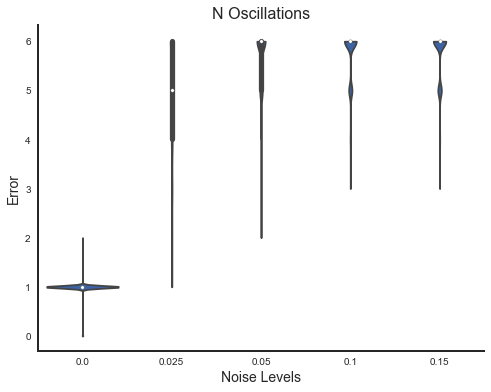

In [35]:
#plot_errors(n_oscs, 'N Oscillations')
plot_errors_violin(n_oscs, 'N Oscillations')

SynParams(background_params=[0, 0.5], gaussian_params=[[19, 0.25, 2.0]], nlv=0.0)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                          0.0003, 0.4998                                          
                                                                                                  
                           

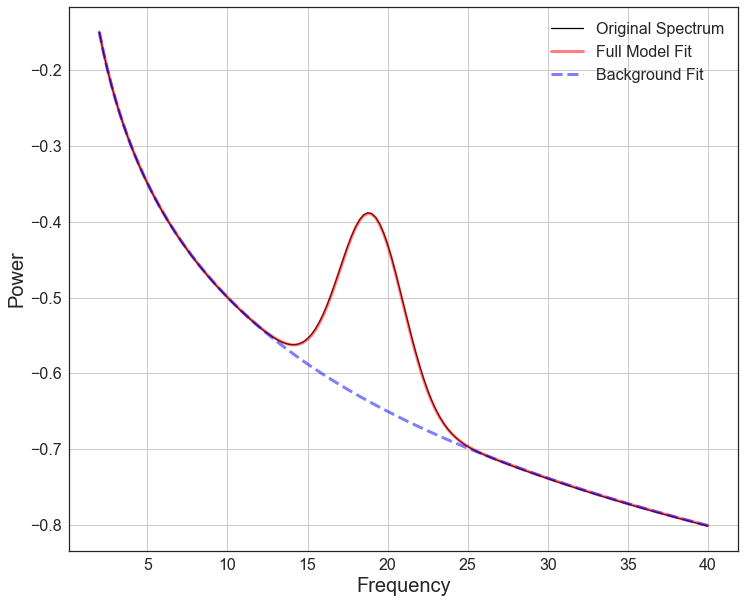

In [36]:
# Grab example cases - low noise
ind = 0
fm_nlv1 = op_fgs[0].get_fooof(ind, True)
print(op_syn_params[0][ind])
fm_nlv1.print_results()
fm_nlv1.plot(save_fig=True, file_name='1Peak-NLV1')

SynParams(background_params=[0, 1.5], gaussian_params=[[14, 0.14999999999999999, 1.0]], nlv=0.15)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                         -0.1880, 1.4271                                          
                                                                                                  
           

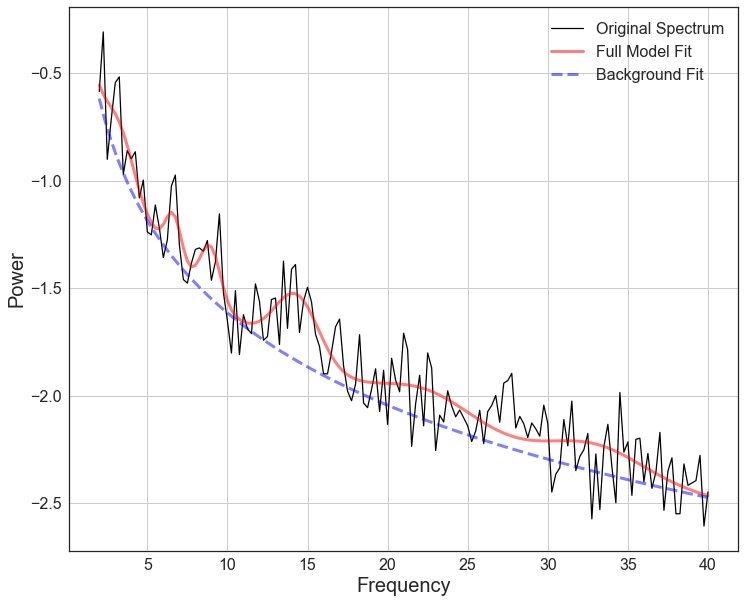

In [37]:
# Grab example cases - high noise
ind = 0
fm_nlv5 = op_fgs[-1].get_fooof(ind, True)
print(op_syn_params[-1][ind])
fm_nlv5.print_results()
fm_nlv5.plot(save_fig=True, file_name='1Peak-NLV5')

## Synthetic Fitting: Multiple Peaks

In [38]:
# Settings for PSD generation
f_range = [2, 40]
f_res = 0.25

# Set the number of PSDs - this is per n_osc condition
n_psds = 1000

# Set the noise levels to use
n_oscs = [0, 1, 2, 3, 4]
nlv = 0.01
#nlvs = [0.0, 0.025, 0.050, 0.10, 0.15]

# Use generators to sample peak & background parameters
peaks = []
for n_osc in n_oscs:
    peaks.append(gen_osc_def(n_osc))
bgs = gen_bg_def()

In [39]:
# Get data sizes
n_n_oscs = len(n_oscs)
n_freqs = int((f_range[1] - f_range[0]) / f_res + 1)

In [40]:
# Generate power spectra
freqs = np.empty(shape=n_freqs)
psds = np.empty(shape=[n_n_oscs, n_psds, n_freqs])
mp_syn_params = [None] * n_n_oscs

#for n_ind, n_osc in enumerate(n_oscs):
for n_ind, n_osc, peaks in zip(range(n_n_oscs), n_oscs, peaks):
    freqs, psds[n_ind, :, :], mp_syn_params[n_ind] = gen_group_power_spectra(n_psds, f_range, bgs, peaks, nlv, f_res)
    
# Check shape
print('n_nlvs, n_spectra, n_freqs : ', psds.shape)

n_nlvs, n_spectra, n_freqs :  (5, 1000, 153)


In [41]:
# Extract ground truth values
peak_truths, bg_truths = get_ground_truth(mp_syn_params)

In [42]:
# Initialize FOOOFGroup to test with
mp_fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6, min_peak_amplitude=0.075)

# Fit power spectra - same FOOOF settings across each group of synthetic power spectra
mp_fgs = fit_fooof_group_3d(mp_fg, freqs, psds)

In [43]:
# Extract data of interest from FOOOF fits
_, bg_fits, err_fits, r2_fits, n_fit_oscs = get_fit_data(mp_fgs)

# Calculate error
bg_errors = np.abs(bg_truths - bg_fits)

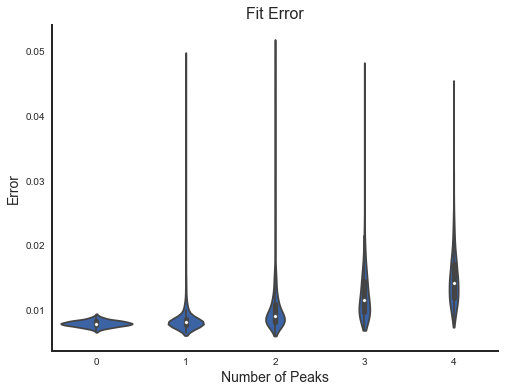

In [44]:
# Multi-peak fitting: plot 
plot_errors_violin(err_fits, 'Fit Error', x_axis='n_oscs', save_fig=True, save_name='MPeak-Err')

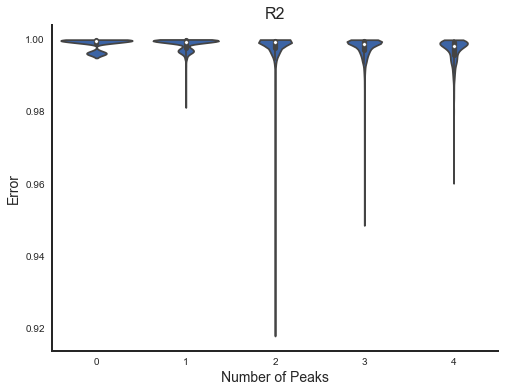

In [45]:
plot_errors_violin(r2_fits, 'R2', x_axis='n_oscs')

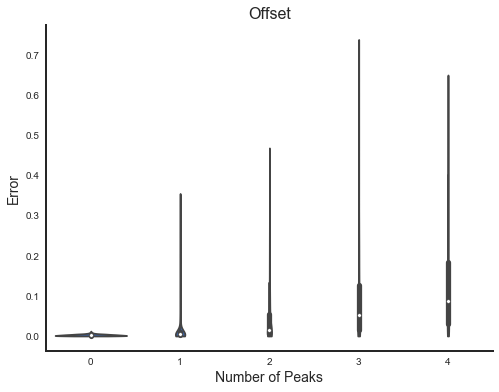

In [46]:
plot_errors_violin(bg_errors[:, :, 0], 'Offset', x_axis='n_oscs')

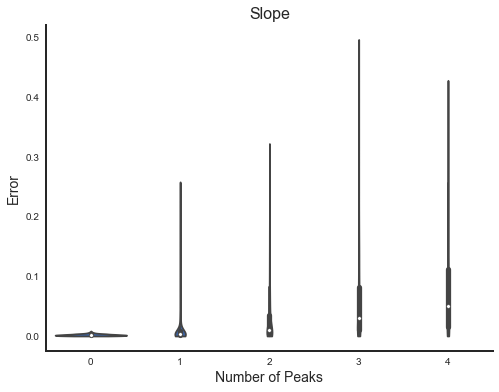

In [47]:
plot_errors_violin(bg_errors[:, :, 1], 'Slope', x_axis='n_oscs')

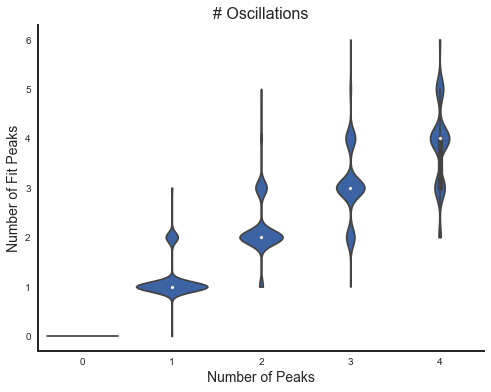

In [48]:
plot_errors_violin(n_fit_oscs, '# Oscillations', x_axis='n_oscs', y_label='Number of Fit Peaks')

In [49]:
# Grab all data for number of peaks simulated
n_actual_oscillations = []
for n in n_oscs:
    n_actual_oscillations.append([n] * n_psds)
n_actual_oscillations = np.array(n_actual_oscillations)
n_actual_oscillations = n_actual_oscillations.flatten()

# Grab data for number of peaks fit
n_fit_oscs = n_fit_oscs.flatten()

# Collect together # simulated & # fit, for plotting
dat = []
for a, b in zip(n_actual_oscillations, n_fit_oscs):
    dat.append((a, b))
n_osc_counter = Counter(dat)

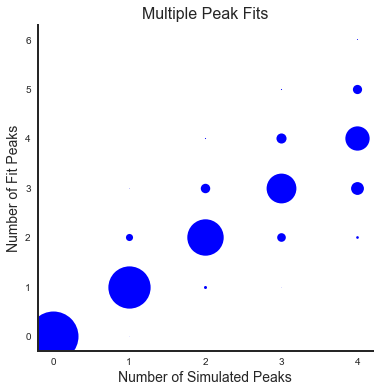

In [50]:
# Plot the correspondance between number of simulated peaks & number of fit peaks
plot_n_oscs_bubbles(n_osc_counter, True)

SynParams(background_params=[0, 2.0], gaussian_params=[[6, 0.40000000000000002, 3.0], [16, 0.14999999999999999, 3.0]], nlv=0.01)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                          0.3316, 2.2208                                          
                                                                               

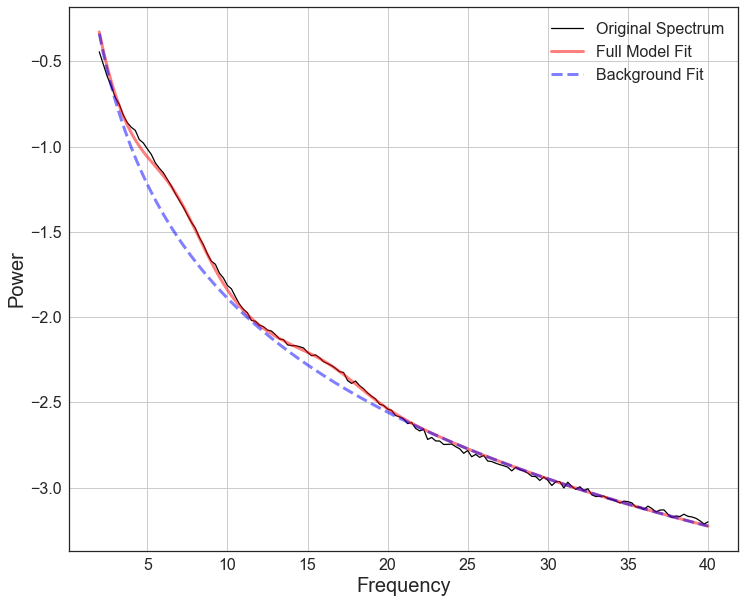

In [51]:
# Grab example case, plot & save out
ind = 1
fm = mp_fgs[2].get_fooof(ind, True)
print(mp_syn_params[2][ind])
fm.print_results()
fm.plot(save_fig=True, file_name='MultiPeak-2P')

SynParams(background_params=[0, 1.5], gaussian_params=[[9, 0.20000000000000001, 2.0], [12, 0.25, 1.0], [17, 0.14999999999999999, 2.0], [28, 0.40000000000000002, 3.0]], nlv=0.01)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                          0.0338, 1.4906                                          
                              

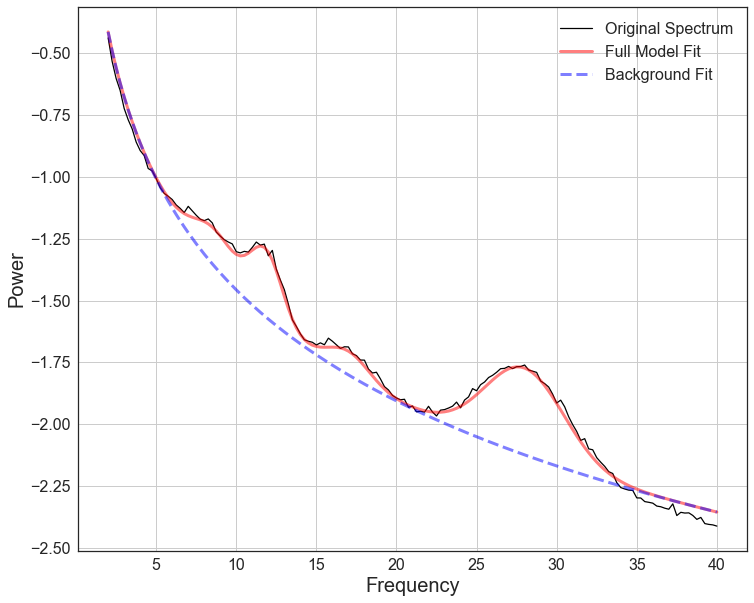

In [59]:
# Grab example case, plot & save out
ind = 10
fm = mp_fgs[-1].get_fooof(ind, True)
print(mp_syn_params[-1][ind])
fm.print_results()
fm.plot(save_fig=True, file_name='MultiPeak-4P')

## Tests

In [53]:
## Tests

from random import choice

def im_a_generator(params):
    while True:
        yield choice(params)
        
def im_callable(params):
    return choice(params)
    #return params[np.random.randint(len(params))]

def test_call(call_me):
    print(im_callable([1, 2, 3]))
    
test_call(im_callable)

3
